In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk
import pydicom
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
from skimage.restoration import denoise_nl_means, estimate_sigma
import ast
# from scipy.ndimage import zoom
# from cupyx.scipy.ndimage import zoom
# import cupy as cp

In [2]:
LABELS_TO_IDX = {
    'Anterior Communicating Artery': 0,
    'Basilar Tip': 1,
    'Left Anterior Cerebral Artery': 2,
    'Left Infraclinoid Internal Carotid Artery': 3,
    'Left Middle Cerebral Artery': 4,
    'Left Posterior Communicating Artery': 5,
    'Left Supraclinoid Internal Carotid Artery': 6,
    'Other Posterior Circulation': 7,
    'Right Anterior Cerebral Artery': 8,
    'Right Infraclinoid Internal Carotid Artery': 9,
    'Right Middle Cerebral Artery': 10,
    'Right Posterior Communicating Artery': 11,
    'Right Supraclinoid Internal Carotid Artery': 12
}


In [3]:

traindf = pd.read_csv("../data/train.csv")
labeldf = pd.read_csv("../data/train_localizers.csv")
traindf = traindf[traindf["SeriesInstanceUID"].isin(labeldf["SeriesInstanceUID"])].reset_index(drop=True)

In [4]:
traindf[traindf["SeriesInstanceUID"] == "1.2.826.0.1.3680043.8.498.10134365079002163886508836892471866754"]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
21,1.2.826.0.1.3680043.8.498.10134365079002163886...,36,Female,MRA,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [5]:
labeldf.head()

,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery


In [6]:
def load_series2vol(series_path, series_id=None, spacing_tolerance=1e-3, resample=False, default_thickness=1.0, max_workers=20):
    reader = sitk.ImageSeriesReader()

    # Get all series IDs
    series_ids = reader.GetGDCMSeriesIDs(series_path)
    if not series_ids:
        raise RuntimeError(f"No DICOM series found in {series_path}")

    # Pick first if not specified
    series_id = str(series_ids[0] if series_id is None else series_id)

    # Get file names for the series
    all_files = reader.GetGDCMSeriesFileNames(series_path, series_id)

    # --- Parallel metadata read (fast size check) ---
    def get_size(f):
        ds = pydicom.dcmread(f, stop_before_pixels=True)
        return (int(ds.Rows), int(ds.Columns)), f, ds

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        sizes = list(ex.map(get_size, all_files))


    # Pick the most common size
    most_common_size = Counter(s[0] for s in sizes).most_common(1)[0][0]
    files = [f for (sz, f, _) in sizes if sz == most_common_size]
    sortedfiles = sorted(sizes, key=lambda s: s[2].ImagePositionPatient[-1])
    sortedfiles = [s[1] for s in sortedfiles]

    # --- Now read the actual image series ---
    reader.SetFileNames(files)
    image = reader.Execute()

    # --- Fix zero thickness ---
    spacing = list(image.GetSpacing())
    if spacing[2] == 0:
        spacing[2] = default_thickness
        image.SetSpacing(spacing)

    # --- Optional resample ---
    if resample and abs(spacing[2] - spacing[0]) > spacing_tolerance:
        new_spacing = [spacing[0], spacing[1], spacing[0]]
        new_size = [
            int(round(image.GetSize()[0] * spacing[0] / new_spacing[0])),
            int(round(image.GetSize()[1] * spacing[1] / new_spacing[1])),
            int(round(image.GetSize()[2] * spacing[2] / new_spacing[2]))
        ]
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(new_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(image.GetDirection())
        resampler.SetOutputOrigin(image.GetOrigin())
        resampler.SetInterpolator(sitk.sitkLinear)
        image = resampler.Execute(image)

    # Convert to numpy array
    volume = sitk.GetArrayFromImage(image)
    return volume, sortedfiles

def apply_cta_window(image, window_level=30, window_width=350):
    """
    Applies a window to the HU values to highlight blood vessels.
    """
    min_val = window_level - window_width // 2
    max_val = window_level + window_width // 2
    windowed_image = np.clip(image, min_val, max_val)
    return windowed_image


def normalize(image):
    """
    Normalizes the image intensity to the range [0, 1].
    """
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val > min_val:
        return (image - min_val) / (max_val - min_val)
    return image

In [7]:
VOL_Z = 256
VOL_Y = 512
VOL_X = 512

In [8]:
idx = 2
UID = traindf.iloc[idx,0]
traindf[traindf["SeriesInstanceUID"] == UID]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,76,Female,MRA,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [9]:
import time

In [11]:
st = time.time()
vol,files = load_series2vol(f"../data/series/{UID}", UID)
row = traindf[traindf["SeriesInstanceUID"] == UID]
modality = row["Modality"].iloc[0]
sopinstances = [f.split("/")[-1][:-4] for f in files]
    
tmp = pydicom.dcmread(f"{files[0]}").pixel_array

assert tmp.shape[0] == vol.shape[1] and tmp.shape[1] == vol.shape[2]

depth,height,width = vol.shape
# vol = cp.asarray(vol)
# vol = zoom(vol, (VOL_Z/depth, VOL_Y/height, VOL_X/width), order=3)
# vol = cp.asnumpy(vol)

depth,height,width = VOL_Z,VOL_Y,VOL_X


coords = [] #z,y,x
location_labels = []
for idx, label in labeldf[labeldf["SeriesInstanceUID"] == UID].iterrows():
    val = ast.literal_eval(label["coordinates"])
    sopuid = label["SOPInstanceUID"]
    z = sopinstances.index(sopuid)
    loc = label["location"]
    location_labels.append(LABELS_TO_IDX[loc])
    # assert z
    coords.append((int(z*VOL_Z/depth), int(val["y"]*VOL_Y/height), int(val["x"]*VOL_X/width)))

print(vol.shape, modality, len(coords))
print(depth,height,width)
print(time.time() - st)

(205, 512, 512) MRA 1
256 512 512
4.49456262588501


ImageSeriesReader (0x55842e705ca0): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000312229



In [14]:
coords

[(112, 209, 189)]

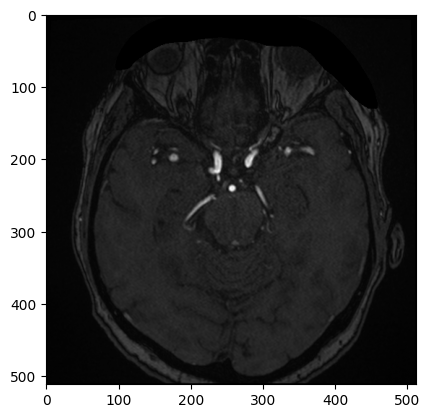

In [13]:
plt.imshow(vol[102], cmap="gray")

In [14]:

tmp = pydicom.dcmread(f"{files[0]}")

getattr(tmp, "ImagePositionPatient")

[-112.2802734375, -279.7802734375, -161.8]

In [16]:

getattr(tmp, "ImagePositionPatient", [0])[-1]

'-161.8'

In [21]:
if modality == "CTA":
    vol = apply_cta_window(vol,)
vol = normalize(vol)

In [24]:
vol = vol * 255

In [26]:
for (z,y,x) in coords:
    vol[int(z)] = cv2.circle(vol[int(z)], (int(x),int(y)), 10, (255,0,0), 1)

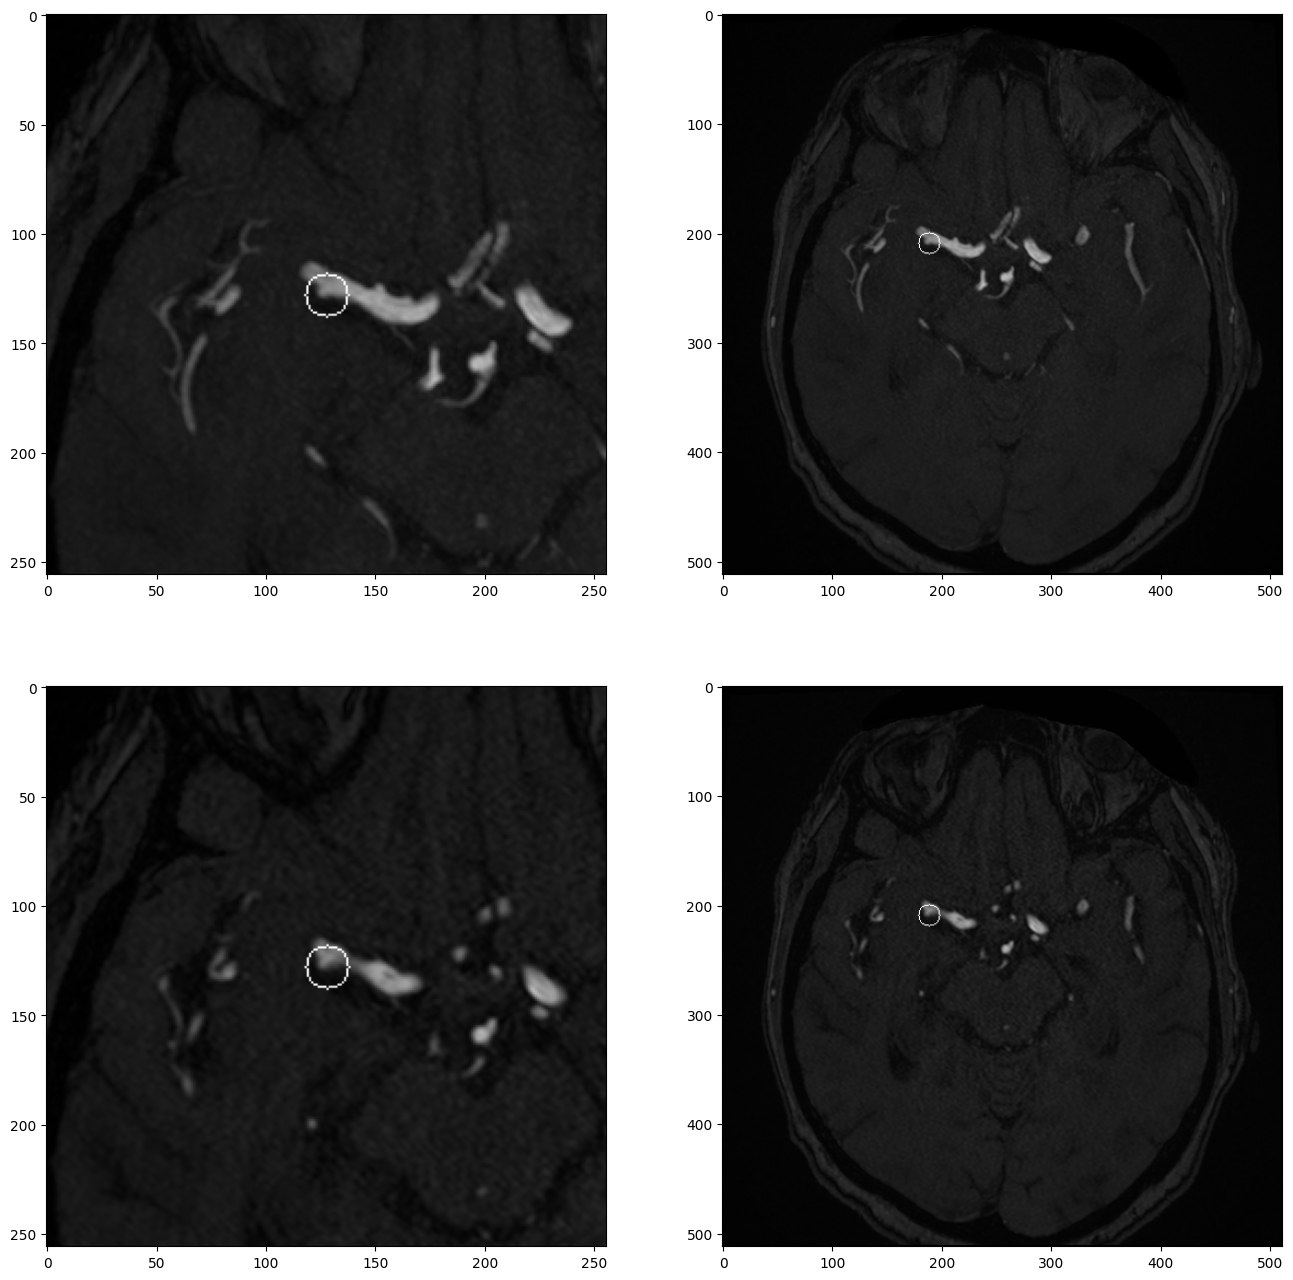

In [32]:
(z1,y1,x1) = coords[0]

fig,axes = plt.subplots(nrows=2,ncols=2, figsize=(16,16))

MIP=4
WIDTH=128

axes[0,0].imshow(corrected_vol[z1-MIP:z1+MIP, y1-WIDTH:y1+WIDTH,x1-WIDTH:x1+WIDTH].max(axis=0), cmap="gray")
axes[0,1].imshow(corrected_vol[z1-MIP:z1+MIP].max(axis=0), cmap="gray")
axes[1,0].imshow(corrected_vol[z1, y1-WIDTH:y1+WIDTH,x1-WIDTH:x1+WIDTH], cmap="gray")
axes[1,1].imshow(corrected_vol[z1], cmap="gray")



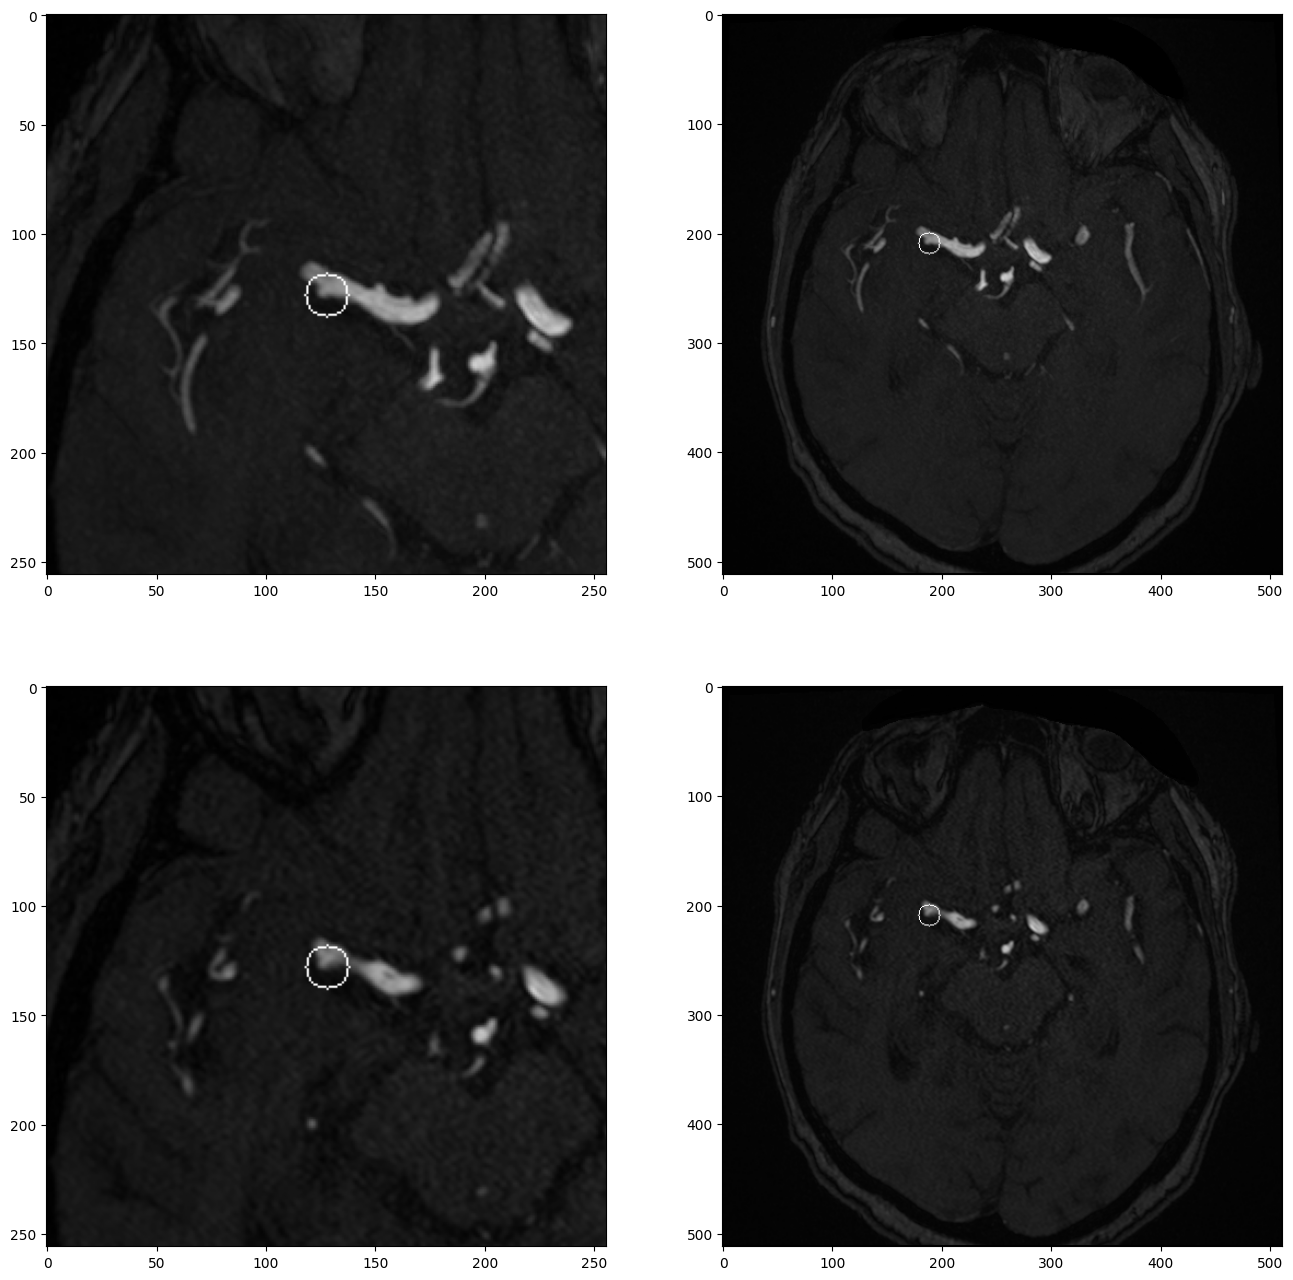

In [27]:
(z1,y1,x1) = coords[0]

fig,axes = plt.subplots(nrows=2,ncols=2, figsize=(16,16))

MIP=4
WIDTH=128

axes[0,0].imshow(vol[z1-MIP:z1+MIP, y1-WIDTH:y1+WIDTH,x1-WIDTH:x1+WIDTH].max(axis=0), cmap="gray")
axes[0,1].imshow(vol[z1-MIP:z1+MIP].max(axis=0), cmap="gray")
axes[1,0].imshow(vol[z1, y1-WIDTH:y1+WIDTH,x1-WIDTH:x1+WIDTH], cmap="gray")
axes[1,1].imshow(vol[z1], cmap="gray")



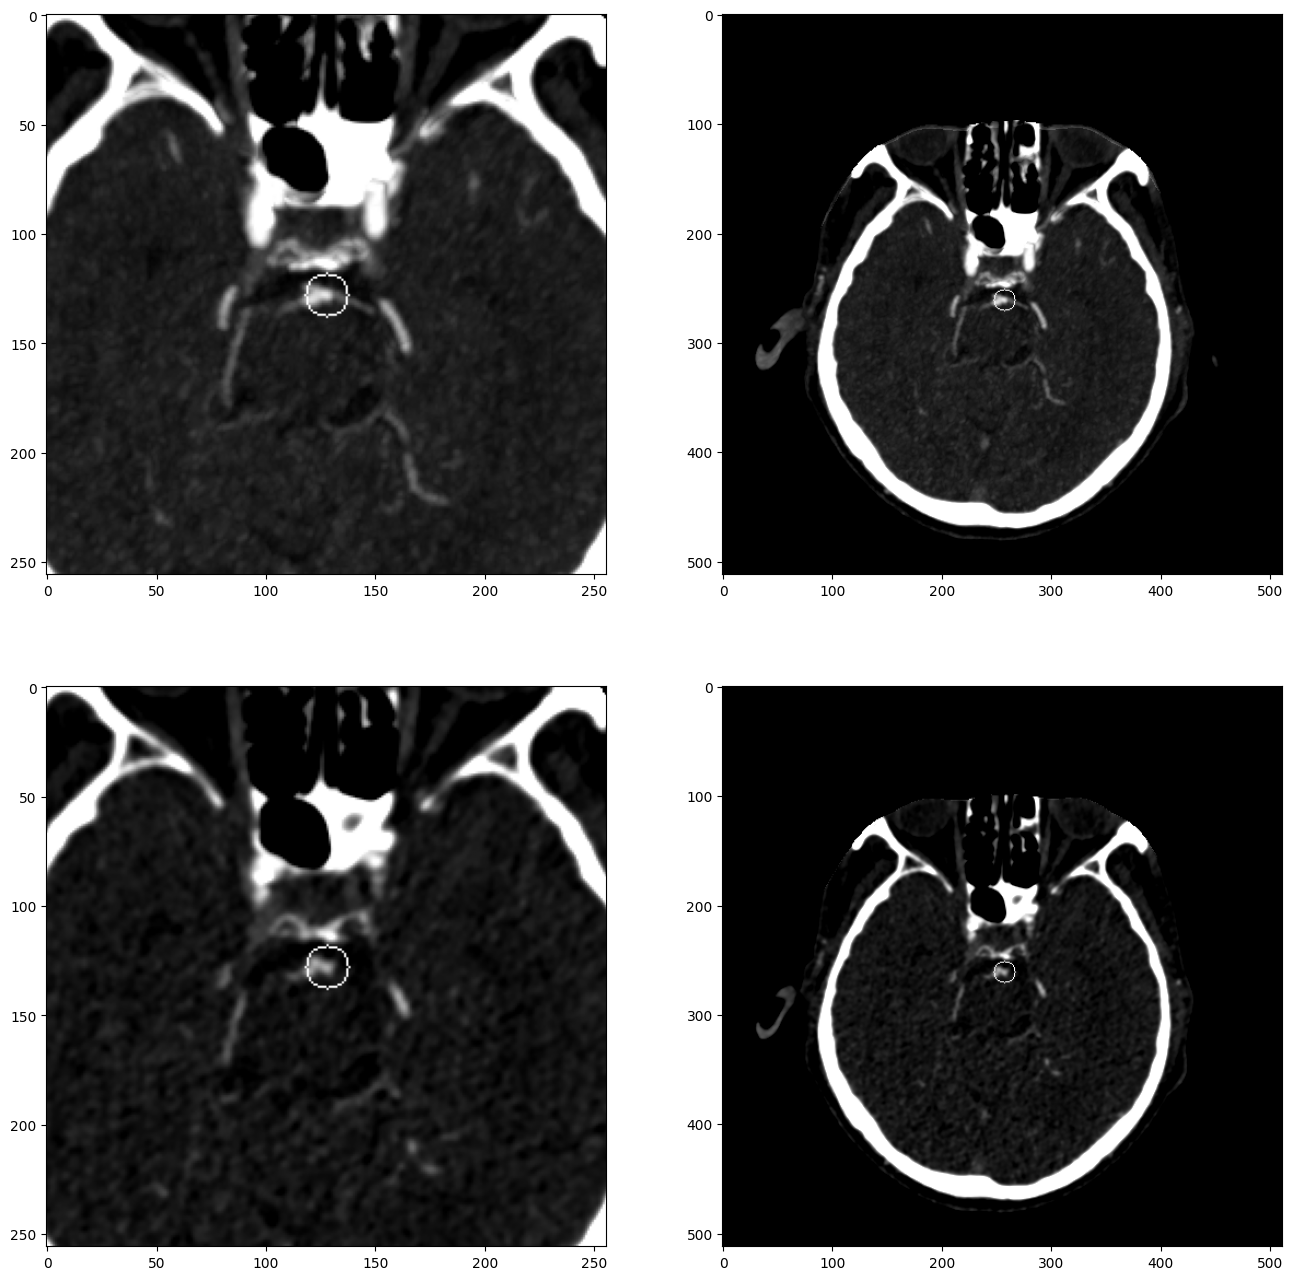

In [15]:
(z1,y1,x1) = coords[0]

fig,axes = plt.subplots(nrows=2,ncols=2, figsize=(16,16))

MIP=4
WIDTH=128

axes[0,0].imshow(vol[z1-MIP:z1+MIP, y1-WIDTH:y1+WIDTH,x1-WIDTH:x1+WIDTH].max(axis=0), cmap="gray")
axes[0,1].imshow(vol[z1-MIP:z1+MIP].max(axis=0), cmap="gray")
axes[1,0].imshow(vol[z1, y1-WIDTH:y1+WIDTH,x1-WIDTH:x1+WIDTH], cmap="gray")
axes[1,1].imshow(vol[z1], cmap="gray")



In [18]:

vol.min(), vol.max()

(np.uint8(0), np.uint8(255))

In [135]:
labeldf[labeldf["SeriesInstanceUID"] == UID]

,SeriesInstanceUID,SOPInstanceUID,coordinates,location
30,1.2.826.0.1.3680043.8.498.10172626607552095496...,1.2.826.0.1.3680043.8.498.60076822750301682237...,"{'x': 242.74330014475882, 'y': 243.7480389897548}",Right Infraclinoid Internal Carotid Artery


In [33]:
traindf.Modality.value_counts()

Modality
CTA           974
MRA           553
MRI T2        258
MRI T1post     77
Name: count, dtype: int64

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from monai.transforms import AsDiscreted, RandCropByLabelClassesd, Compose, MapTransform

# from monai.transforms.croppad import rand

import glob

import pandas as pd
import torch

In [8]:
traindf = pd.read_csv("../data/train.csv")
labeldf = pd.read_csv("../data/train_localizers.csv")

traindf = traindf[traindf["SeriesInstanceUID"].isin(labeldf["SeriesInstanceUID"])].reset_index(drop=True)

In [9]:
uids = [f.split("/")[-1][:-4] for f in glob.glob("../data/processed/*.npz")]
traindf = traindf[traindf["SeriesInstanceUID"].isin(uids)].reset_index(drop=True)

In [10]:
import sys
sys.path.append("..")
sys.path.append("../..")

from rsna.src.rsna_datasets.segmentation import WindowedMIP

A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [11]:
class dotdict(dict):
    """Dot-access dictionary."""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [12]:
cfg = {
    "params": dotdict({
        "data_path": "../data/processed",
        "num_classes": 14,
        "sliding_stride": dotdict({ "cta": 8, "mr": 16 }),
        "spatial_size": dotdict({ "cta": [4,128,128], "mr": [32,128,128] }),
        "img_width": 256,
        "img_height": 256,
        "radius": 5,
        "validation": dotdict({"output_img": [512,512], "patch_size": [128,128]})
    })
}

cfg

{'params': {'data_path': '../data/processed',
  'num_classes': 14,
  'sliding_stride': {'cta': 8, 'mr': 16},
  'spatial_size': {'cta': [4, 128, 128], 'mr': [32, 128, 128]},
  'img_width': 256,
  'img_height': 256,
  'radius': 5,
  'validation': {'output_img': [512, 512], 'patch_size': [128, 128]}}}

In [13]:
cfg = dotdict(cfg)

In [14]:
ds = WindowedMIP(uids, cfg, mode="train")

In [15]:
idx = 5
img, mask = ds[idx]

In [16]:
patch_mip,patch_slice,slice,slice_mip = img

In [17]:
traindf[traindf["SeriesInstanceUID"] == uids[idx]]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
1063,1.2.826.0.1.3680043.8.498.53330781707385844603...,62,Female,MRA,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [18]:
mask.shape, mask.max()

((256, 256), np.uint8(11))

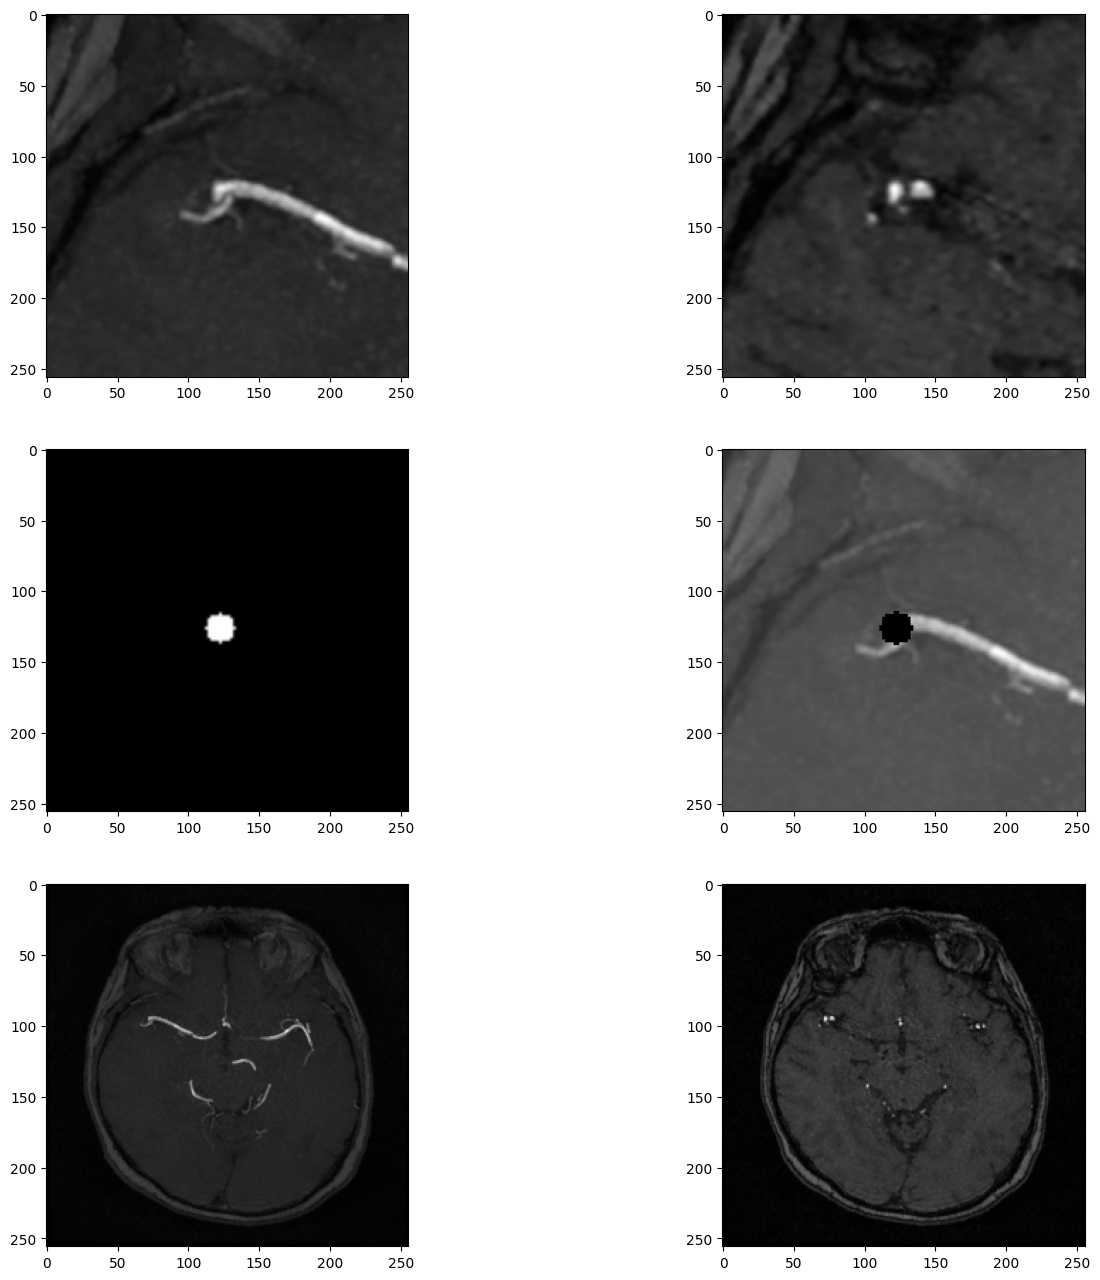

In [19]:
fig,axes = plt.subplots(nrows=3,ncols=2, figsize=(16,16))


axes[0,0].imshow(patch_mip, cmap="gray")
axes[0,1].imshow(patch_slice, cmap="gray")

axes[1,0].imshow(mask, cmap="gray")
tmp = patch_mip.copy()
tmp[mask != 0] = 0
axes[1,1].imshow(tmp, cmap="gray")

axes[2,0].imshow(slice, cmap="gray")
axes[2,1].imshow(slice_mip, cmap="gray")



In [20]:
import torch
import pytorch_lightning as pl
from hydra.utils import instantiate
import numpy as np
import torch.nn.functional as F

from monai.losses.dice import DiceCELoss
from monai.inferers.inferer import Inferer
from monai.inferers.splitter import SlidingWindowSplitter
from monai.inferers.merger import AvgMerger, Merger

torch.set_float32_matmul_precision('medium')


In [102]:
class WindowedMIPInferer(Inferer):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.validation_params = self.cfg.params.validation
        self.splitter = SlidingWindowSplitter((128,128))
        # Use full image size, not patch size
        self.merger = AvgMerger(merged_shape=(1,1,512,512))

    def __call__(self, x, model):
        print(x.shape)
        img_width, img_height = self.cfg.params.img_width, self.cfg.params.img_height

        patches, locs = [], []
        for patch, loc in self.splitter(x):
            patches.append(patch)  # keep whole (B,C,H,W)
            locs.append(loc)

        # self.merger.initalize()
        # self.merger.aggregate(patches, locs)
       
        for patch, loc in zip(patches, locs):
            print(patch.shape, loc)
            # assume batch=1, but keep all channels
            self.merger.aggregate(patch, loc)  # shape (C,H,W)
        
        y = self.merger.finalize()
        return y


In [103]:
ds = WindowedMIP(uids, cfg, mode="val")

In [104]:
xs,ys = ds[2]

In [105]:
inferer = WindowedMIPInferer(cfg)

In [106]:
xs[26][0].shape

(512, 512)

In [112]:
ys.shape

(32, 512, 512)

In [107]:
y = inferer(torch.from_numpy(xs[26][0]).unsqueeze(0).unsqueeze(0), None)

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 128, 128]) (0, 0)
torch.Size([1, 1, 128, 128]) (0, 128)
torch.Size([1, 1, 128, 128]) (0, 256)
torch.Size([1, 1, 128, 128]) (0, 384)
torch.Size([1, 1, 128, 128]) (128, 0)
torch.Size([1, 1, 128, 128]) (128, 128)
torch.Size([1, 1, 128, 128]) (128, 256)
torch.Size([1, 1, 128, 128]) (128, 384)
torch.Size([1, 1, 128, 128]) (256, 0)
torch.Size([1, 1, 128, 128]) (256, 128)
torch.Size([1, 1, 128, 128]) (256, 256)
torch.Size([1, 1, 128, 128]) (256, 384)
torch.Size([1, 1, 128, 128]) (384, 0)
torch.Size([1, 1, 128, 128]) (384, 128)
torch.Size([1, 1, 128, 128]) (384, 256)
torch.Size([1, 1, 128, 128]) (384, 384)


In [108]:
y

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [109]:
y.shape

torch.Size([1, 1, 512, 512])

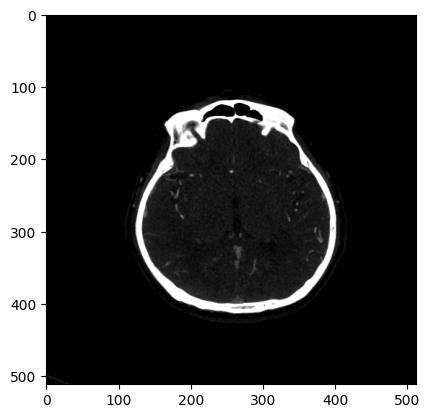

In [110]:
plt.imshow(y.squeeze(), cmap="gray")

In [33]:
traindf[traindf["SeriesInstanceUID"] == uids[0]]

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
293,1.2.826.0.1.3680043.8.498.11975102890487716267...,54,Female,CTA,0,0,0,0,0,0,1,0,0,0,0,0,0,1


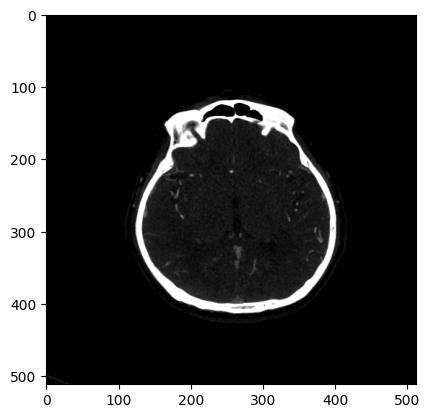

In [175]:
plt.imshow(xs[26][0], cmap="gray")

In [111]:
xs.shape

(32, 2, 512, 512)

In [117]:
xs.transpose(0,2,3,1).shape

(32, 512, 512, 2)

In [34]:
tmp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(512, 512), dtype=int16)

In [3]:
import os
from pathlib import Path
import pandas as pd

In [4]:
traindf = pd.read_csv("../data/train.csv")

In [5]:
uid = traindf.iloc[0,0]

In [20]:
data_path = Path("../data")
series_path = data_path.joinpath(f"series/{uid}")
all_filepaths = sorted([
    os.path.join(root, file)
    for root, _, files in os.walk(series_path)
    for file in files if file.endswith('.dcm')
])


In [25]:
[*map(lambda x: x.split("/")[-1][:-4], all_filepaths)]

['1.2.826.0.1.3680043.8.498.10124807242473374136099471315028464450',
 '1.2.826.0.1.3680043.8.498.10138383895715496920719014209752366343',
 '1.2.826.0.1.3680043.8.498.10163629202066490350525656863994550563',
 '1.2.826.0.1.3680043.8.498.10168500191766317056991929548420609601',
 '1.2.826.0.1.3680043.8.498.10229246287448303586334999931645148833',
 '1.2.826.0.1.3680043.8.498.10314871018551672540885268304038443011',
 '1.2.826.0.1.3680043.8.498.10333534100756165373591313965530162035',
 '1.2.826.0.1.3680043.8.498.10402291067741894444758238077775726419',
 '1.2.826.0.1.3680043.8.498.10486211606858414516699231337500956997',
 '1.2.826.0.1.3680043.8.498.10517225444888619475163956382223622124',
 '1.2.826.0.1.3680043.8.498.10539829370105743308434271256984603393',
 '1.2.826.0.1.3680043.8.498.10676452078924881901296423855445745451',
 '1.2.826.0.1.3680043.8.498.10719573586801164115860773932315039550',
 '1.2.826.0.1.3680043.8.498.10720671472588344924613435980369881260',
 '1.2.826.0.1.3680043.8.498.108940

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom

In [47]:
sample = np.load("../data/processed/series/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647.npz")

In [48]:
vol = sample["vol"]

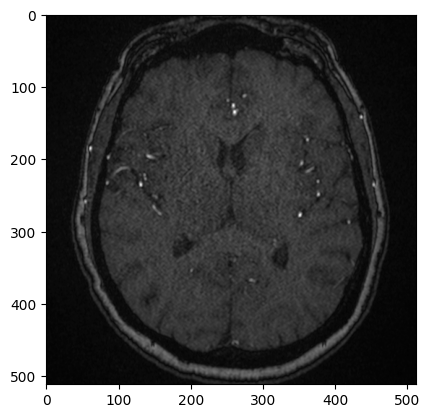

In [56]:
plt.imshow(vol[48], cmap="gray")

In [40]:
uid = "1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647"

In [42]:
import glob

In [43]:
files = [*glob.glob(f"../data/series/{uid}/*.dcm")]

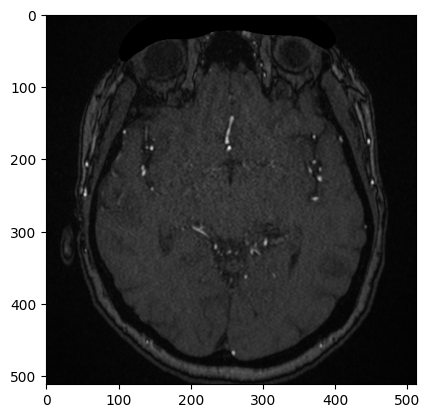

In [44]:
plt.imshow(pydicom.dcmread(files[0]).pixel_array, cmap="gray")

In [45]:
vol.max()

np.uint8(255)

In [7]:
import pandas as pd
import numpy as np
# import 
import glob
import pydicom
from tqdm import tqdm

In [8]:
df = pd.read_csv("../data/train.csv")
labeldf = pd.read_csv("../data/train_localizers.csv")

In [9]:
labeldf["SOPInstanceUID"]

0       1.2.826.0.1.3680043.8.498.10775329348174902199...
1       1.2.826.0.1.3680043.8.498.53868409774237283281...
2       1.2.826.0.1.3680043.8.498.24186535344744886473...
3       1.2.826.0.1.3680043.8.498.75217084841854214544...
4       1.2.826.0.1.3680043.8.498.71237104731452368587...
                              ...                        
2246    1.2.826.0.1.3680043.8.498.12398549862508001109...
2247    1.2.826.0.1.3680043.8.498.12398549862508001109...
2248    1.2.826.0.1.3680043.8.498.21598979799967012280...
2249    1.2.826.0.1.3680043.8.498.21598979799967012280...
2250    1.2.826.0.1.3680043.8.498.65157374409757364881...
Name: SOPInstanceUID, Length: 2251, dtype: object

In [23]:
data = {
    "uid": [],
    "modality": [],
    "z": [],
    "total": []
}


for idx, seriesdf in tqdm(df.iterrows()):
    uid = seriesdf["SeriesInstanceUID"]
    modality = seriesdf["Modality"]
    labels = labeldf[labeldf["SeriesInstanceUID"] == uid]
    total = len(glob.glob(f"../data/series/{uid}/*.dcm"))

    try:
        for idx, label in labels.iterrows():
            ds = pydicom.dcmread(f"../data/series/{uid}/{label['SOPInstanceUID']}.dcm")
            z = ds.InstanceNumber
            if (z < total):
                data["uid"].append(uid)
                data["modality"].append(modality)
                data["total"].append(total)
                data["z"].append(z)
            

    except Exception as e:
        print(f"Not able to process: {uid}")

528it [00:00, 1175.15it/s]

Not able to process: 1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068


2188it [00:01, 1441.79it/s]

Not able to process: 1.2.826.0.1.3680043.8.498.35204126697881966597435252550544407444


4348it [00:03, 1383.70it/s]


In [24]:
# !ls ../data/series/1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068/
!ls ../data/series/1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068/1.2.826.0.1.3680043.8.498.11359680660692538603323710088085312565.dcm

ls: cannot access '../data/series/1.2.826.0.1.3680043.8.498.11145695452143851764832708867797988068/1.2.826.0.1.3680043.8.498.11359680660692538603323710088085312565.dcm': No such file or directory


In [25]:
locdf = pd.DataFrame(data)

In [26]:
for m,gdf in locdf.groupby("modality"):
    print(m)
    print((gdf["z"] / gdf["total"]).describe())

CTA
count    1217.000000
mean        0.502561
std         0.171652
min         0.002924
25%         0.353535
50%         0.483755
75%         0.663793
max         0.979424
dtype: float64
MRA
count    556.000000
mean       0.512108
std        0.125186
min        0.006579
25%        0.444902
50%        0.506098
75%        0.586260
max        0.982906
dtype: float64
MRI T1post
count    92.000000
mean      0.465692
std       0.133263
min       0.200000
25%       0.374432
50%       0.430845
75%       0.535985
max       0.944444
dtype: float64
MRI T2
count    214.000000
mean       0.452813
std        0.130745
min        0.160714
25%        0.375000
50%        0.423077
75%        0.482439
max        0.944444
dtype: float64


In [28]:
import pandas as pd

In [30]:
pd.read_csv("../data/processed/train.csv")["fold_id"].value_counts()

fold_id
0    870
2    870
1    870
4    869
3    869
Name: count, dtype: int64

In [33]:
import matplotlib.pyplot as plt

In [34]:
vol = np.load("../data/processed/series/1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647.npz")["vol"]

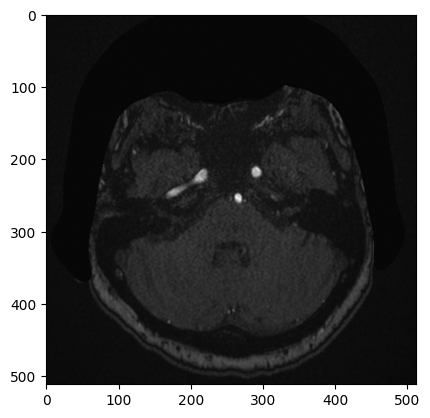

In [41]:
plt.imshow(vol[21], cmap="gray")

In [42]:
vol.max()

np.uint8(255)